<a href="https://colab.research.google.com/github/UnlimitedDreamCo/bulk-clip-interrogator/blob/main/bulk_clip_interrogator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bulk CLIP Interrogator 

Interrogate a folder of images and output the results as a CSV.

Modified by [@unltd_dream_co](https://twitter.com/unltd_dream_co). Original notebook by [@pharmapsychotic](https://twitter.com/pharmapsychotic).


What do the different OpenAI CLIP models see in an image? What might be a good text prompt to create similar images using CLIP guided diffusion or another text to image model? The CLIP Interrogator is here to get you answers!

If this notebook is helpful to you please consider buying me a coffee via [ko-fi](https://ko-fi.com/pharmapsychotic) or following me on [twitter](https://twitter.com/pharmapsychotic) for more cool Ai stuff. 🙂

And if you're looking for more Ai art tools check out my [Ai generative art tools list](https://pharmapsychotic.com/tools.html).


In [ ]:
#@title Check GPU
!nvidia-smi -L

GPU 0: A100-SXM4-40GB (UUID: GPU-5ad0ef32-9f43-18f6-5050-00873a1b3e00)


In [ ]:
#@title Setup
!pip3 install ftfy regex tqdm transformers==4.15.0 timm==0.4.12 fairscale==0.4.4
!pip3 install git+https://github.com/openai/CLIP.git
!git clone https://github.com/UnlimitedDreamCo/bulk-clip-interrogator.git
!git clone https://github.com/salesforce/BLIP
%cd /content/BLIP

import clip
import gc
import numpy as np
import os
import pandas as pd
import requests
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from IPython.display import display
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from models.blip import blip_decoder

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

blip_image_eval_size = 384
blip_model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model*_base_caption.pth'        
blip_model = blip_decoder(pretrained=blip_model_url, image_size=blip_image_eval_size, vit='base')
blip_model.eval()
blip_model = blip_model.to(device)

def generate_caption(pil_image):
    gpu_image = transforms.Compose([
        transforms.Resize((blip_image_eval_size, blip_image_eval_size), interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    ])(image).unsqueeze(0).to(device)

    with torch.no_grad():
        caption = blip_model.generate(gpu_image, sample=False, num_beams=3, max_length=20, min_length=5)
    return caption[0]

def load_list(filename):
    with open(filename, 'r', encoding='utf-8', errors='replace') as f:
        items = [line.strip() for line in f.readlines()]
    return items

def rank(model, image_features, text_array, top_count=1):
    top_count = min(top_count, len(text_array))
    text_tokens = clip.tokenize([text for text in text_array]).cuda()
    with torch.no_grad():
        text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

    similarity = torch.zeros((1, len(text_array))).to(device)
    for i in range(image_features.shape[0]):
        similarity += (100.0 * image_features[i].unsqueeze(0) @ text_features.T).softmax(dim=-1)
    similarity /= image_features.shape[0]

    top_probs, top_labels = similarity.cpu().topk(top_count, dim=-1)  
    return [(text_array[top_labels[0][i].numpy()], (top_probs[0][i].numpy()*100)) for i in range(top_count)]

prompt_output = ""

def interrogate(image, models):
    global prompt_output
    caption = generate_caption(image)
    if len(models) == 0:
        print(f"\n\n{caption}")
        return

    table = []
    bests = [[('',0)]]*5
    for model_name in models:
        print(f"Interrogating with {model_name}...")
        model, preprocess = clip.load(model_name)
        model.cuda().eval()

        images = preprocess(image).unsqueeze(0).cuda()
        with torch.no_grad():
            image_features = model.encode_image(images).float()
        image_features /= image_features.norm(dim=-1, keepdim=True)

        ranks = [
            rank(model, image_features, mediums),
            rank(model, image_features, ["by "+artist for artist in artists]),
            rank(model, image_features, trending_list),
            rank(model, image_features, movements),
            rank(model, image_features, flavors, top_count=3)
        ]

        for i in range(len(ranks)):
            confidence_sum = 0
            for ci in range(len(ranks[i])):
                confidence_sum += ranks[i][ci][1]
            if confidence_sum > sum(bests[i][t][1] for t in range(len(bests[i]))):
                bests[i] = ranks[i]

        row = [model_name]
        for r in ranks:
            row.append(', '.join([f"{x[0]} ({x[1]:0.1f}%)" for x in r]))

        table.append(row)

        del model
        gc.collect()
    display(pd.DataFrame(table, columns=["Model", "Medium", "Artist", "Trending", "Movement", "Flavors"]))

    flaves = ', '.join([f"{x[0]}" for x in bests[4]])
    medium = bests[0][0][0]
    if caption.startswith(medium):
        prompt_output = f"{caption} {bests[1][0][0]}, {bests[2][0][0]}, {bests[3][0][0]}, {flaves}"
        print(prompt_output)
    else:
        prompt_output = f"{caption}, {medium} {bests[1][0][0]}, {bests[2][0][0]}, {bests[3][0][0]}, {flaves}"
        print(prompt_output)
        
data_path = "../clip-interrogator/data/"

artists = load_list(os.path.join(data_path, 'artists.txt'))
flavors = load_list(os.path.join(data_path, 'flavors.txt'))
mediums = load_list(os.path.join(data_path, 'mediums.txt'))
movements = load_list(os.path.join(data_path, 'movements.txt'))

sites = ['Artstation', 'behance', 'cg society', 'cgsociety', 'deviantart', 'dribble', 'flickr', 'instagram', 'pexels', 'pinterest', 'pixabay', 'pixiv', 'polycount', 'reddit', 'shutterstock', 'tumblr', 'unsplash', 'zbrush central']
trending_list = [site for site in sites]
trending_list.extend(["trending on "+site for site in sites])
trending_list.extend(["featured on "+site for site in sites])
trending_list.extend([site+" contest winner" for site in sites])


In [ ]:
#@title Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Files and directories in a specified path:
Unknown-7.png


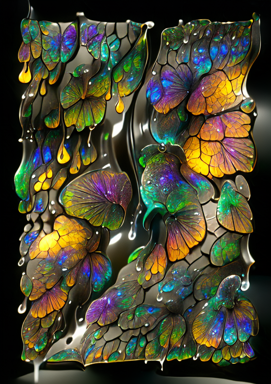

Interrogating with ViT-B/32...
Interrogating with ViT-B/16...
Interrogating with RN50...


,Model,Medium,Artist,Trending,Movement,Flavors
0,ViT-B/32,an airbrush painting (30.3%),by Louis Comfort Tiffany (13.7%),behance (20.9%),cloisonnism (27.0%),"iridescent (17.1%), stained glass (15.6%), air..."
1,ViT-B/16,a computer rendering (24.0%),by Mike Winkelmann (1.1%),trending on cgsociety (14.6%),cloisonnism (16.9%),"stained glass (30.7%), iridescent (8.0%), made..."
2,RN50,an airbrush painting (61.3%),by Louis Comfort Tiffany (11.8%),featured on pixabay (9.8%),art nouveau (38.2%),"airbrush art (36.0%), iridescent (16.8%), stai..."


a painting of butterflies and leaves on a black background, an airbrush painting by Louis Comfort Tiffany, behance, art nouveau, airbrush art, iridescent, stained glass
Unknown-24.png


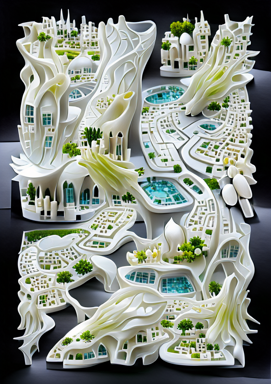

Interrogating with ViT-B/32...
Interrogating with ViT-B/16...
Interrogating with RN50...


,Model,Medium,Artist,Trending,Movement,Flavors
0,ViT-B/32,an art deco sculpture (59.6%),by Zaha Hadid (30.2%),behance (28.3%),ecological art (35.3%),"biomorphic (13.3%), art deco (11.5%), intricat..."
1,ViT-B/16,a marble sculpture (58.1%),by Zaha Hadid (34.0%),behance (11.2%),ecological art (21.1%),"marble sculpture (25.9%), high detailed (16.9%..."
2,RN50,an ambient occlusion render (26.8%),by Zaha Hadid (12.8%),featured on polycount (18.5%),ecological art (15.5%),"biomorphic (28.2%), diorama (8.7%), cityscape ..."


a model of a city with a lot of trees and buildings, an art deco sculpture by Zaha Hadid, behance, ecological art, marble sculpture, high detailed, cityscape
Unknown-27.png


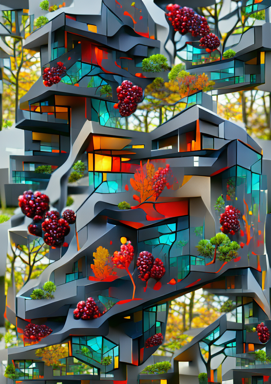

Interrogating with ViT-B/32...
Interrogating with ViT-B/16...
Interrogating with RN50...


,Model,Medium,Artist,Trending,Movement,Flavors
0,ViT-B/32,a 3D render (18.3%),by Tim Biskup (2.5%),behance contest winner (21.4%),modular constructivism (17.4%),"rendered in cinema4d (10.2%), vray (8.2%), mad..."
1,ViT-B/16,a low poly render (37.7%),by Ernő Rubik (1.3%),behance contest winner (21.4%),modular constructivism (14.5%),"made of vines (9.5%), rendered in maya (7.8%),..."
2,RN50,a digital rendering (69.3%),by Buckminster Fuller (0.8%),behance contest winner (13.2%),hypermodernism (12.6%),"isometric (28.2%), cubism (4.2%), voxel art (3..."


a multi - level building with a lot of windows and trees, a digital rendering by Tim Biskup, behance contest winner, modular constructivism, isometric, cubism, voxel art
Unknown-29.png


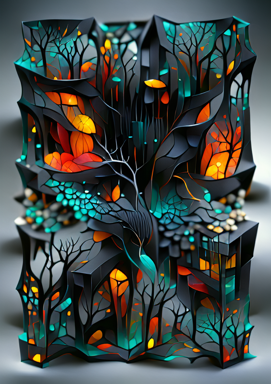

Interrogating with ViT-B/32...
Interrogating with ViT-B/16...
Interrogating with RN50...


,Model,Medium,Artist,Trending,Movement,Flavors
0,ViT-B/32,an abstract sculpture (26.2%),by Kilian Eng (4.2%),behance contest winner (28.5%),fantasy art (10.6%),"rendered in cinema4d (11.7%), voxel art (6.0%)..."
1,ViT-B/16,a low poly render (18.2%),"by Kim Myeong-guk, (2.0%)",trending on behance (33.7%),fantasy art (18.9%),"stained glass (13.8%), low poly (10.0%), intri..."
2,RN50,a digital rendering (11.6%),by Eyvind Earle (2.9%),featured on polycount (16.7%),ecological art (10.3%),"digital illustration (7.8%), detailed painting..."


a paper cut out of a city with trees and buildings, an abstract sculpture by Kilian Eng, trending on behance, fantasy art, stained glass, low poly, intricate
Unknown-31.png


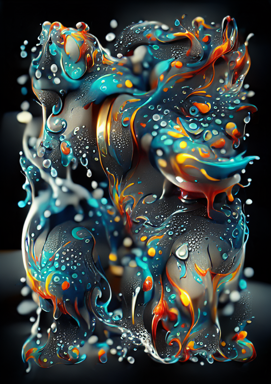

Interrogating with ViT-B/32...
Interrogating with ViT-B/16...
Interrogating with RN50...


,Model,Medium,Artist,Trending,Movement,Flavors
0,ViT-B/32,an airbrush painting (39.8%),by Alberto Seveso (8.6%),behance (26.3%),psychedelic art (22.5%),"behance hd (18.5%), airbrush art (18.3%), deta..."
1,ViT-B/16,an airbrush painting (49.5%),by Sam Spratt (22.0%),featured on behance (19.1%),kinetic art (37.1%),"behance hd (23.9%), airbrush art (9.8%), rende..."
2,RN50,an airbrush painting (48.4%),by Alberto Seveso (7.0%),behance contest winner (18.7%),psychedelic art (25.8%),"airbrush art (30.6%), detailed painting (6.4%)..."


a digital painting of a bunch of bubbles, an airbrush painting by Sam Spratt, behance, kinetic art, behance hd, airbrush art, detailed painting


In [ ]:
#@title Interrogate!

#@markdown 

#@markdown #####**Image folder path**

folder= '/content/drive/MyDrive/clip'#@param {type:"string"}

#@markdown #####**Output CSV file path**

output_file= '/content/drive/MyDrive/clip3.csv'#@param {type:"string"}
#@markdown 

#@markdown #####**CLIP models:**

#@markdown For [StableDiffusion](https://stability.ai/blog/stable-diffusion-announcement) you can just use ViTL14<br>
#@markdown For [DiscoDiffusion](https://colab.research.google.com/github/alembics/disco-diffusion/blob/main/Disco_Diffusion.ipynb) and 
#@markdown [JAX](https://colab.research.google.com/github/huemin-art/jax-guided-diffusion/blob/v2.7/Huemin_Jax_Diffusion_2_7.ipynb) enable all the same models here as you intend to use when generating your images

ViTB32 = True #@param{type:"boolean"}
ViTB16 = True #@param{type:"boolean"}
ViTL14 = False #@param{type:"boolean"}
ViTL14_336px = False #@param{type:"boolean"}
RN101 = False #@param{type:"boolean"}
RN50 = True #@param{type:"boolean"}
RN50x4 = False #@param{type:"boolean"}
RN50x16 = False #@param{type:"boolean"}
RN50x64 = False #@param{type:"boolean"}

models = []
if ViTB32: models.append('ViT-B/32')
if ViTB16: models.append('ViT-B/16')
if ViTL14: models.append('ViT-L/14')
if ViTL14_336px: models.append('ViT-L/14@336px')
if RN101: models.append('RN101')
if RN50: models.append('RN50')
if RN50x4: models.append('RN50x4')
if RN50x16: models.append('RN50x16')
if RN50x64: models.append('RN50x64')

import os
import csv

prompt_list = [["Filename", "Prompt"]]
for filename in os.listdir(folder):
    f = os.path.join(folder,filename)
    if os.path.isfile(f):
        print(filename)
        image = Image.open(f).convert('RGB')
        thumb = image.copy()
        thumb.thumbnail([blip_image_eval_size, blip_image_eval_size])
        display(thumb)
        interrogate(image, models=models)
        prompt_list.append([filename, prompt_output])

with open(output_file, 'w', newline='') as file:
    writer = csv.writer(file, quoting=csv.QUOTE_MINIMAL)
    writer.writerows(prompt_list)